<a href="https://colab.research.google.com/github/gopalkalpande/Caltech101/blob/master/caltech101_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/data/caltech_101/'

101_ObjectCategories  data


In [0]:
import pandas as pd

from sklearn.model_selection import train_test_split

import shutil
import os


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import cv2
from matplotlib import pyplot as plt

import keras
print("keras version: ", keras.__version__)

import tensorflow as tf
print("tensoflow version: ", tf.__version__)

# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.9
 
# Create a session with the above options specified.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


keras version:  2.2.4
tensoflow version:  1.13.1


In [5]:
dataset_path = '/content/drive/My Drive/data/caltech_101/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(dataset_path))]

print(len(folder_names)) # 102 = 101 categories + background

102


In [0]:
# directories to use. Run the other cells ONLY ONCE to create the splitting

base_path = '/content/drive/My Drive/data/caltech_101/101_ObjectCategories'
train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'validation')
test_dir = os.path.join(base_path, 'test')


In [7]:
!ls '/content/drive/My Drive/data/caltech_101/'


101_ObjectCategories  data


In [8]:
category_dict = {}
images_per_category_dict = {}
category_images_path_dict = {}

total_images = 0

for i, category in enumerate(folder_names):
    category_dict[i] = category
    
    folder_path = dataset_path + '/' + category
    #image_names = [os.path.join(folder_path, img) for img in sorted(os.listdir(folder_path))]
    image_names = [img for img in sorted(os.listdir(folder_path))]
    
    images_per_category_dict[i] = len(image_names)
    category_images_path_dict[i] = image_names
    
    print('%s: %d' %(category, images_per_category_dict[i]))
    total_images += images_per_category_dict[i]
    
print('Total images in dataset: %d' %(total_images))


BACKGROUND_Google: 468
Faces: 435
Faces_easy: 435
Leopards: 200
Motorbikes: 798
accordion: 55
airplanes: 800
anchor: 42
ant: 42
barrel: 47
bass: 54
beaver: 46
binocular: 33
bonsai: 128
brain: 98
brontosaurus: 43
buddha: 85
butterfly: 91
camera: 50
cannon: 43
car_side: 123
ceiling_fan: 47
cellphone: 59
chair: 62
chandelier: 107
cougar_body: 47
cougar_face: 69
crab: 73
crayfish: 70
crocodile: 50
crocodile_head: 51
cup: 57
dalmatian: 67
dollar_bill: 52
dolphin: 65
dragonfly: 68
electric_guitar: 75
elephant: 64
emu: 53
euphonium: 64
ewer: 85
ferry: 67
flamingo: 67
flamingo_head: 45
garfield: 34
gerenuk: 34
gramophone: 51
grand_piano: 99
hawksbill: 100
headphone: 42
hedgehog: 54
helicopter: 88
ibis: 80
inline_skate: 31
joshua_tree: 64
kangaroo: 86
ketch: 114
lamp: 61
laptop: 81
llama: 78
lobster: 41
lotus: 66
mandolin: 43
mayfly: 40
menorah: 87
metronome: 32
minaret: 76
nautilus: 55
octopus: 35
okapi: 39
pagoda: 47
panda: 38
pigeon: 45
pizza: 53
platypus: 34
pyramid: 57
revolver: 82
rhino: 

In [11]:
'''# create the directories to use
base_path = '/content/drive/My Drive/data/caltech_101/data'
os.mkdir(base_path)

train_dir = os.path.join(base_path, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_path, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_path, 'test')
os.mkdir(test_dir)
'''


"# create the directories to use\nbase_path = '/content/drive/My Drive/data/caltech_101/data'\nos.mkdir(base_path)\n\ntrain_dir = os.path.join(base_path, 'train')\nos.mkdir(train_dir)\n\nvalidation_dir = os.path.join(base_path, 'validation')\nos.mkdir(validation_dir)\n\ntest_dir = os.path.join(base_path, 'test')\nos.mkdir(test_dir)\n"

In [10]:
!ls '/content/drive/My Drive/data/caltech_101/data'

test  train  validation


In [0]:
# create the categories files in each
'''
for directory in [train_dir, validation_dir, test_dir]:
    for category in folder_names:
        os.mkdir(os.path.join(directory, category))
'''

In [0]:
# calculate the number of images to place in each train/valid/test categories folder
'''
total_train = 0
total_validation = 0
total_test = 0

total_train_2 = 0
total_validation_2 = 0
total_test_2 = 0

for i, category in enumerate(folder_names):
    train_number = int(0.7 * images_per_category_dict[i])
    validation_number = int(0.2 * images_per_category_dict[i])
    test_number = images_per_category_dict[i] - train_number - validation_number # for not exceeding maximum number
    
    # for statistics later
    total_train += train_number
    total_validation += validation_number
    total_test += test_number
    
    # now copy these images to respective folders
    # Copy first 1000 cat images to train_cats_dir
    fnames = category_images_path_dict[i][:train_number]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(train_dir, category, fname)
        shutil.copyfile(src, dst)
        
    total_train_2 += len(fnames)
        
    fnames = category_images_path_dict[i][train_number:train_number + validation_number]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(validation_dir, category, fname)
        shutil.copyfile(src, dst)
        
    total_validation_2 += len(fnames)
    
    fnames = category_images_path_dict[i][train_number + validation_number:]
    for fname in fnames:
        src = os.path.join(dataset_path, category, fname)
        dst = os.path.join(test_dir, category, fname)
        shutil.copyfile(src, dst)
        
    total_test_2 += len(fnames)
'''

KeyboardInterrupt: ignored

In [0]:
'''print('Correct train split: ', total_train == total_train_2)
print('Correct validation split: ', total_validation == total_validation_2)
print('Correct test split: ', total_test == total_test_2)
print()
print('Number of training images: ', total_train)
print('Number of validation images: ', total_validation)
print('Number of test images: ', total_test)
print()
print('Real percentage of training images: ', total_train / total_images)
print('Real percentage of validation images: ', total_validation / total_images)
print('Real percentage of test images: ', total_test / total_images)
'''

In [0]:
#!ls "/content/drive/My Drive/data/caltech_101/data/train"


In [14]:
Y_train = []
path = "/content/drive/My Drive/data/caltech_101/data/train"
for label in os.listdir(os.path.join(path)):
    back_path = os.path.join(path,label)
    for filename in os.listdir(back_path):
        Y_train.append(label)
len(Y_train)


3239

In [15]:
Y_test = []
path = "/content/drive/My Drive/data/caltech_101/data/test"
for label in os.listdir(os.path.join(path)):
    back_path = os.path.join(path,label)
    for filename in os.listdir(back_path):
        Y_test.append(label)

len(Y_test)


481

In [16]:
Y_valid = []
path = "/content/drive/My Drive/data/caltech_101/data/validation"
for label in os.listdir(os.path.join(path)):
    back_path = os.path.join(path,label)
    for filename in os.listdir(back_path):
        Y_valid.append(label)

len(Y_valid)


905

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y_train)
Y_train= le.transform(Y_train)
Y_valid= le.transform(Y_valid)
Y_test= le.transform(Y_test)



In [0]:
train_dir = "/content/drive/My Drive/data/caltech_101/data/train"
validation_dir = "/content/drive/My Drive/data/caltech_101/data/validation"
test_dir = "/content/drive/My Drive/data/caltech_101/data/test"


In [89]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')



Found 3238 images belonging to 102 classes.
Found 905 images belonging to 102 classes.


In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers
import numpy as np

In [51]:
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
from keras import models
from keras.models import Model
from keras import layers

In [0]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 102 classes
predictions = Dense(102, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [91]:
len(model.trainable_weights)

192

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [93]:
len(model.trainable_weights)

4

In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [95]:
model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/2
100/100 [==============================] - 41s 415ms/step - loss: 1.6836 - acc: 0.6110 - val_loss: 1.3278 - val_acc: 0.7503
Epoch 2/2
100/100 [==============================] - 11s 109ms/step - loss: 0.8644 - acc: 0.7657 - val_loss: 1.1220 - val_acc: 0.8213


In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [0]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [98]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/50
100/100 [==============================] - 45s 453ms/step - loss: 0.9843 - acc: 0.7625 - val_loss: 10.4146 - val_acc: 0.2822
Epoch 2/50
100/100 [==============================] - 13s 130ms/step - loss: 0.6514 - acc: 0.8544 - val_loss: 1.4614 - val_acc: 0.7888
Epoch 3/50
100/100 [==============================] - 12s 119ms/step - loss: 0.4006 - acc: 0.8884 - val_loss: 2.7442 - val_acc: 0.6832
Epoch 4/50
100/100 [==============================] - 12s 121ms/step - loss: 0.2929 - acc: 0.9275 - val_loss: 1.6770 - val_acc: 0.8183
Epoch 5/50
100/100 [==============================] - 12s 118ms/step - loss: 0.2130 - acc: 0.9414 - val_loss: 0.8473 - val_acc: 0.8751
Epoch 6/50
100/100 [==============================] - 12s 121ms/step - loss: 0.2329 - acc: 0.9314 - val_loss: 0.7891 - val_acc: 0.8711
Epoch 7/50
100/100 [==============================] - 12s 121ms/step - loss: 0.1541 - acc: 0.9540 - val_loss: 0.4829 - val_acc: 0.9107
Epoch 8/50
100/100 [==============================] - 

In [99]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


Found 480 images belonging to 102 classes.
test acc: 0.9039999949932098


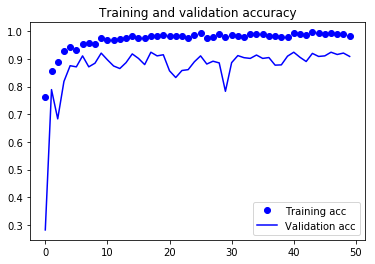

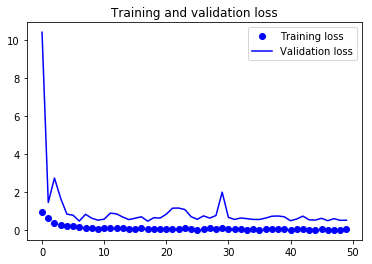

In [100]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [101]:
model.save("/content/drive/My Drive/data/caltech_101/caltech_InceptionV3_2.h5")

!ls "/content/drive/My Drive/data/caltech_101/"


101_ObjectCategories	  caltech_InceptionV3_2.h5  data
caltech_InceptionV3_1.h5  caltech_resnet_1.h5


# Expt 2:

In [102]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 102 classes
predictions = Dense(102, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

len(model.trainable_weights)

192

In [103]:
for layer in base_model.layers:
    layer.trainable = False

len(model.trainable_weights)


4

In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])


In [105]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')


Found 3238 images belonging to 102 classes.


In [106]:
model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50)


Epoch 1/2
100/100 [==============================] - 57s 565ms/step - loss: 1.9860 - acc: 0.5360 - val_loss: 1.6871 - val_acc: 0.6680
Epoch 2/2
100/100 [==============================] - 19s 193ms/step - loss: 1.1776 - acc: 0.6746 - val_loss: 1.0713 - val_acc: 0.7584


In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True


In [0]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])


In [109]:
%%time
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)


Epoch 1/50
100/100 [==============================] - 61s 608ms/step - loss: 1.1225 - acc: 0.7005 - val_loss: 1.2448 - val_acc: 0.7990
Epoch 2/50
100/100 [==============================] - 20s 203ms/step - loss: 0.7480 - acc: 0.7933 - val_loss: 1.0385 - val_acc: 0.8030
Epoch 3/50
100/100 [==============================] - 20s 201ms/step - loss: 0.6358 - acc: 0.8126 - val_loss: 1.3895 - val_acc: 0.7619
Epoch 4/50
100/100 [==============================] - 21s 208ms/step - loss: 0.4956 - acc: 0.8595 - val_loss: 1.0997 - val_acc: 0.8152
Epoch 5/50
100/100 [==============================] - 21s 209ms/step - loss: 0.4768 - acc: 0.8673 - val_loss: 0.8361 - val_acc: 0.8609
Epoch 6/50
100/100 [==============================] - 20s 201ms/step - loss: 0.4694 - acc: 0.8712 - val_loss: 0.6979 - val_acc: 0.8711
Epoch 7/50
100/100 [==============================] - 20s 202ms/step - loss: 0.4195 - acc: 0.8785 - val_loss: 0.6587 - val_acc: 0.8701
Epoch 8/50
100/100 [==============================] - 2

In [110]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


Found 480 images belonging to 102 classes.
test acc: 0.8849999952316284


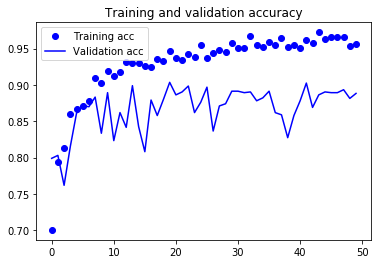

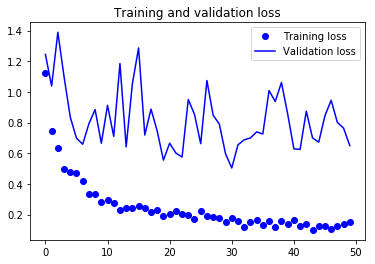

In [111]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [112]:
model.save("/content/drive/My Drive/data/caltech_101/caltech_InceptionV3_1.h5")

!ls "/content/drive/My Drive/data/caltech_101/"


101_ObjectCategories	  caltech_InceptionV3_2.h5  data
caltech_InceptionV3_1.h5  caltech_resnet_1.h5
